# M5 Product Selection (Multi-Store, Seasonal, Non-Sparse)

This notebook scans the M5 dataset (`dataset/m5 dataset/`) to find a single **item_id** that:
- appears in many stores (broad coverage),
- has mostly non-zero daily demand (not sparse),
- shows **weekly** and **yearly** seasonality (autocorrelation at lags 7 and ~365),
- spans 2–4+ years of history.

It then ranks candidates and lets you export tidy `Date,demand` CSVs per store for the chosen item, so you can plug them into your simulator (1–2–4 network etc.).

In [14]:
from pathlib import Path
import numpy as np
import pandas as pd

sales = pd.read_csv('sales_train_validation.csv')
calendar = pd.read_csv('calendar.csv')[['d','date']]
day_cols = [c for c in sales.columns if c.startswith('d_')]
print('Rows:', len(sales), '| Day columns:', len(day_cols))

Rows: 30490 | Day columns: 1913


## Compute per-store series metrics (no melt)

In [15]:
vals = sales[day_cols].to_numpy(dtype=np.float32)

nonzero_ratio = (vals > 0).mean(axis=1)
mean_demand = vals.mean(axis=1)

def autocorr_at_lag(arr, lag):
    if lag <= 0 or lag >= arr.shape[0]:
        return np.nan
    a = arr[:-lag]; b = arr[lag:]
    sa, sb = a.std(), b.std()
    if sa == 0 or sb == 0:
        return 0.0
    import numpy as _np
    return _np.corrcoef(a, b)[0,1]

acf7   = np.array([autocorr_at_lag(vals[i], 7)   for i in range(vals.shape[0])], dtype=np.float32)
acf364 = np.array([autocorr_at_lag(vals[i], 364) for i in range(vals.shape[0])], dtype=np.float32)

row_metrics = pd.DataFrame({
    'item_id': sales['item_id'],
    'store_id': sales['store_id'],
    'state_id': sales['state_id'],
    'dept_id': sales['dept_id'],
    'cat_id': sales['cat_id'],
    'nonzero_ratio': nonzero_ratio,
    'mean_demand': mean_demand,
    'acf7': acf7,
    'acf364': acf364,
})
row_metrics.head()

,item_id,store_id,state_id,dept_id,cat_id,nonzero_ratio,mean_demand,acf7,acf364
0,HOBBIES_1_001,CA_1,CA,HOBBIES_1,HOBBIES,0.220073,0.313643,0.210216,0.193477
1,HOBBIES_1_002,CA_1,CA,HOBBIES_1,HOBBIES,0.210141,0.257710,0.069021,0.141081
2,HOBBIES_1_003,CA_1,CA,HOBBIES_1,HOBBIES,0.112912,0.150549,0.280631,0.072090
3,HOBBIES_1_004,CA_1,CA,HOBBIES_1,HOBBIES,0.677470,1.718766,0.210717,0.173853
4,HOBBIES_1_005,CA_1,CA,HOBBIES_1,HOBBIES,0.503398,0.966545,0.100484,0.103025


### Filter good store-series & aggregate to item level

In [16]:
# Tunables
NONZERO_MIN = 0.80  # >=60% of days with demand > 0
MEAN_MIN    = 10  # avoid extremely tiny level
COVERAGE_MIN = 8    # require at least 4 good stores for 1–2–4 network

row_metrics['is_good_store_series'] = (row_metrics['nonzero_ratio'] >= NONZERO_MIN) & (row_metrics['mean_demand'] >= MEAN_MIN)

agg = (row_metrics
       .groupby('item_id')
       .agg(
           stores_covered=('is_good_store_series', 'sum'),
           stores_total=('store_id', 'nunique'),
           avg_nonzero=('nonzero_ratio', 'mean'),
           med_acf7=('acf7', 'median'),
           med_acf364=('acf364', 'median'),
           mean_level=('mean_demand', 'mean'),
       )
       .reset_index())

agg = agg.sort_values(['stores_covered','avg_nonzero','med_acf364','med_acf7','mean_level'], ascending=False)

candidates = agg[agg['stores_covered'] >= COVERAGE_MIN].copy()

def top_stores_for_item(item, k=8):
    sub = row_metrics[(row_metrics.item_id==item) & (row_metrics.is_good_store_series)]
    return list(sub.sort_values(['nonzero_ratio','acf364','acf7','mean_demand'], ascending=False)['store_id'].head(k))

candidates['example_stores'] = candidates['item_id'].apply(lambda x: ','.join(top_stores_for_item(x, k=8)))
candidates.head(50)

,item_id,stores_covered,stores_total,avg_nonzero,med_acf7,med_acf364,mean_level,example_stores
1198,FOODS_3_586,10,10,0.995400,0.567291,0.448225,48.104652,"CA_2,CA_3,WI_3,CA_1,TX_3,TX_2,WI_1,CA_4"
1325,FOODS_3_714,10,10,0.991218,0.507446,0.350986,20.709461,"WI_3,CA_1,CA_3,TX_3,TX_2,CA_4,WI_1,CA_2"
1306,FOODS_3_694,8,10,0.993257,0.406513,0.301154,20.386879,"CA_3,WI_3,CA_1,TX_3,WI_1,TX_2,WI_2,TX_1"
1167,FOODS_3_555,8,10,0.991636,0.549065,0.376977,25.681494,"TX_2,CA_3,WI_3,CA_1,CA_2,TX_3,TX_1,WI_2"
864,FOODS_3_252,8,10,0.987193,0.565865,0.389492,29.550390,"TX_2,CA_1,TX_3,CA_3,CA_2,WI_3,TX_1,CA_4"


### Pick one item and export per-store tidy series

In [25]:
def export_item_store_series(sales_df, calendar_df, item_id, stores, out_dir='processed'):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    day_cols = [c for c in sales_df.columns if c.startswith('d_')]
    sub = sales_df[(sales_df['item_id']==item_id) & (sales_df['store_id'].isin(stores))].copy()
    if sub.empty:
        raise ValueError(f'No rows for {item_id} in stores {stores}')
    written = []
    for _, row in sub.iterrows():
        store = row['store_id']
        ts = row[day_cols].rename_axis('d').reset_index(name='demand')
        ts = ts.merge(calendar_df[['d','date']], on='d', how='left').rename(columns={'date':'Date'})
        ts = ts[['Date','demand']]
        path = out_dir / f'{store}.csv'
        ts.to_csv(path, index=False)
        written.append(str(path))
    return written

# Example usage:
# chosen_item = candidates.iloc[0]['item_id']
# stores = top_stores_for_item(chosen_item, k=4)
# export_item_store_series(sales, calendar, chosen_item, stores)

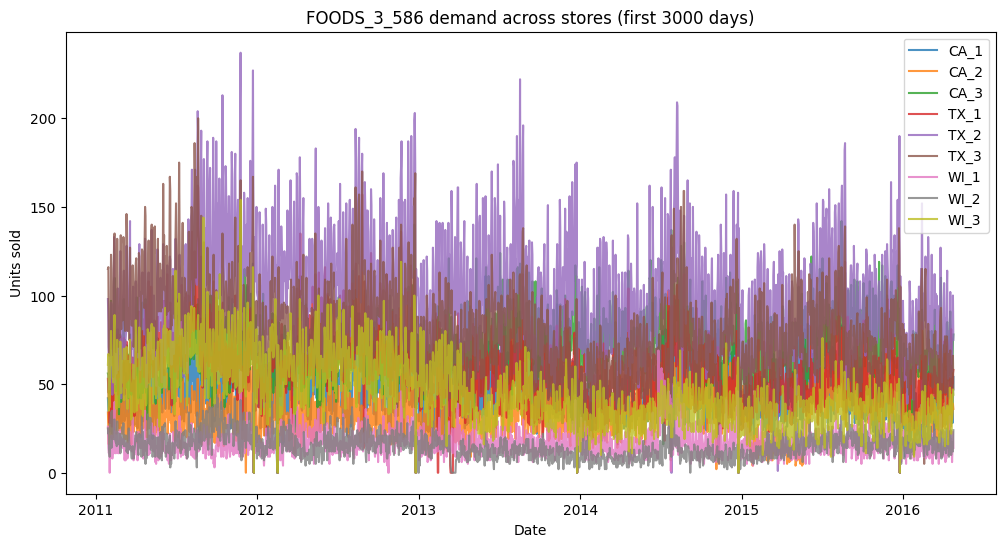

In [18]:
import matplotlib.pyplot as plt

def plot_item_multi_store(sales_df, calendar_df, item_id, stores, days=1000):
    day_cols = [c for c in sales_df.columns if c.startswith("d_")]
    cal_map = dict(zip(calendar_df["d"], calendar_df["date"]))
    dates = pd.to_datetime([cal_map[d] for d in day_cols])
    
    plt.figure(figsize=(12,6))
    for store in stores:
        row = sales_df[(sales_df["item_id"]==item_id) & (sales_df["store_id"]==store)]
        if row.empty: 
            continue
        series = row[day_cols].values.flatten()
        plt.plot(dates[:days], series[:days], label=store, alpha=0.8)
    plt.title(f"{item_id} demand across stores (first {days} days)")
    plt.xlabel("Date")
    plt.ylabel("Units sold")
    plt.legend()
    plt.show()

# Example: plot 3 stores for FOODS_3_586
plot_item_multi_store(sales, calendar, "FOODS_3_586", ["CA_1","CA_2", "CA_3", "TX_1","TX_2","TX_3","WI_1","WI_2","WI_3"], days=3000)


In [26]:
# Example usage:
chosen_item = candidates.iloc[0]['item_id']
stores = top_stores_for_item(chosen_item, k=10)
export_item_store_series(sales, calendar, chosen_item, stores)

['processed/CA_1.csv',
 'processed/CA_2.csv',
 'processed/CA_3.csv',
 'processed/CA_4.csv',
 'processed/TX_1.csv',
 'processed/TX_2.csv',
 'processed/TX_3.csv',
 'processed/WI_1.csv',
 'processed/WI_2.csv',
 'processed/WI_3.csv']

In [30]:
from pathlib import Path
import json

# Locate the processed folder robustly
PROC = Path("processed")
if not PROC.exists():
    PROC = Path("dataset/m5_dataset/processed")
assert PROC.exists(), f"Can't find processed folder at {PROC.resolve()}"

# Build a clean manifest: file paths relative to the manifest's folder
files = {p.stem: p.name for p in sorted(PROC.glob("*.csv"))}  # "CA_1": "CA_1.csv", ...

manifest = {
    "files": files,
    "date_col": "date",
    "qty_col": "demand",
}

(PROC / "manifest.json").write_text(json.dumps(manifest, indent=2))
print("✅ Rewrote manifest at:", (PROC / "manifest.json").resolve())

# Sanity check: resolve what the simulator will read
for sid, name in list(files.items())[:3]:
    print(sid, "->", (PROC / name).resolve())



✅ Rewrote manifest at: /home/sakthe/Desktop/DDP/dataset/m5_dataset/processed/manifest.json
CA_1 -> /home/sakthe/Desktop/DDP/dataset/m5_dataset/processed/CA_1.csv
CA_2 -> /home/sakthe/Desktop/DDP/dataset/m5_dataset/processed/CA_2.csv
CA_3 -> /home/sakthe/Desktop/DDP/dataset/m5_dataset/processed/CA_3.csv
